In [1]:
from qpe import *

from time import time
from scipy.stats import gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info(dms, labels, n_layers, pars, n_copies=1, n_meas=0):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    d_diff = 2**(n_tot - n_meas)
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    # CX_cascade = cx_cascade(n_tot)
    # ansatz = hea_cx_rzrx(n_tot, n_layers, CX_cascade, pars_ans)

    obs_u = ansatz.conj().T@kron_A_N(diag(pars_est), d_diff)@ansatz
    obs_u_sq = obs_u@obs_u
    
    # projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    # projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]
    
    expecs = []
    disps = []
    # for j in range(len(labels)): # take a density matrix from the training set
    #     print(j, end="\r")
    #     probs = [trace(dms_cop[j]@proj).real for proj in projs_u]
    #     expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
    #     disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
    #     expecs.append(expec)
    #     disps.append(disp)
    for dm in dms_cop:
        expec = trace(dm@obs_u).real
        disp = trace(dm@obs_u_sq).real - expec**2
        expecs.append(expec)
        disps.append(disp)
        
    
    return array(expecs), array(disps)

### Settings

In [13]:
n_inp = 2
n_train = 1000
n_test = 10000
mixed = True
marks = "neg"

dms_train, labels_train = gen_even_ent_data(n_train, n_inp=n_inp, mixed=mixed, marks=marks)
dms_test, labels_test = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)
purities_test = [trace(dm@dm).real for dm in dms_test]

In [14]:
w_ls = 1e0
w_var = 1e-4
method = "BFGS"
options = {"maxiter": int(1e4)}#, "maxfun": int(1e10)}#

In [4]:
path = r"/home/kardashin/Work/Quantum channel estimation/Results/Entanglement/Negativity/"
info = "T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_train, w_ls, w_var, marks, mixed)

In [6]:
# np.save(path + info + "-labels_train", labels_train)
# np.save(path + info + "-dms_train", dms_train)

#### 1 copy start

In [12]:
n_copies_1 = 1
n_meas_1 = n_inp*n_copies_1
n_tot_1 = n_inp*n_copies_1
n_layers_1 = 2

x0 = concatenate([normal(pi/2, 0.1, (3*n_tot_1 - 1)*n_layers_1 + 2*n_tot_1), normal(0, 1e-2, 2**n_meas_1)])
# x0 = concatenate([uniform(0, 2*pi, (3*n_tot_1 - 1)*n_layers_1 + 2*n_tot_1), uniform(-1, 1, 2**n_meas_1)])
# x0 = array(pars)

file_name = path + "c=%d-m=%d-l=%d-" %(n_copies_1, n_meas_1, n_layers_1) + info + "-pars"

time_start_1 = time()
fvals_1, result_1 = train(dms_train, labels_train, n_layers_1, method=method, 
                          n_copies=n_copies_1, n_meas=n_meas_1, w_ls=w_ls, w_var=w_var, 
                          options=options, x0=x0, save_data=True, file_name=file_name)
time_finish_1 = time() - time_start_1
print("\n\nFinished in", time_finish_1)
print("Cost:", result_1.fun)
print(result_1.message)
pars_1 = result_1.x

Iteration: 46 | Function value: 82.12439592

Finished in 8.817894458770752
Cost: 82.12439592397153
Optimization terminated successfully.


In [13]:
expecs_train_1, disps_train_1 = aux_info(dms_train, labels_train, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)
expecs_test_1, disps_test_1 = aux_info(dms_test, labels_test, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)

n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.08458612074522805


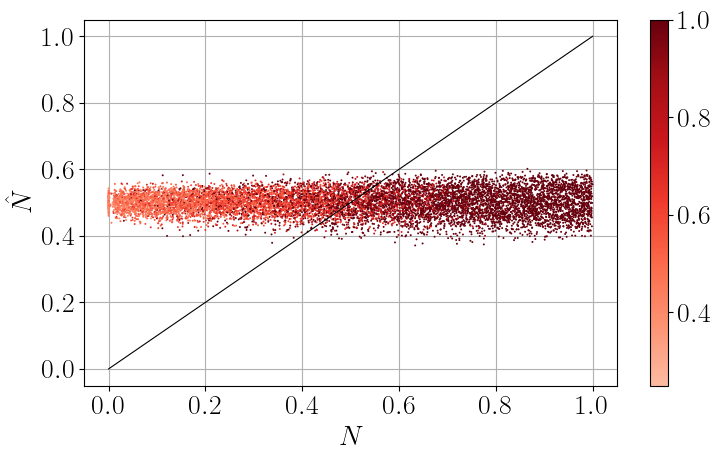

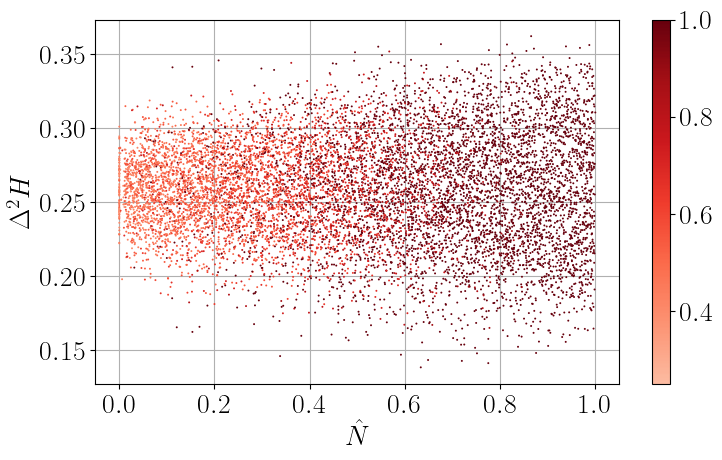

In [15]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_1, n_meas_1, n_layers_1))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))


cmap_name = "Reds"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_1 = sum(np.abs(labels_test - expecs_test_1)**2)/n_test
print("\nError:", sum_err_test_1)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_1, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

#### 2 copies

In [5]:
n_copies_2 = 2
n_layers_2 = 2
n_tot_2 = n_inp*n_copies_2
n_meas_2 = n_inp*n_copies_2

# x0_2 = prev_to_next_ansatz(pars_1, n_tot_1, n_meas_1, n_layers_1, n_tot_2, n_meas_2, n_layers_2, subsval=0)
x0_2 = concatenate([normal(pi/2, 0.1, (3*n_tot_2 - 1)*n_layers_2 + 2*n_tot_2), normal(0, 1e-2, 2**n_meas_2)])

file_name = path + "c=%d-m=%d-l=%d-" %(n_copies_2, n_meas_2, n_layers_2) + info + "-pars"

In [15]:
time_start_2 = time()
fvals_2, result_2 = train(dms_train, labels_train, n_layers_2, 
                          n_copies=n_copies_2, n_meas=n_meas_2, x0=x0_2,
                          method=method, w_ls=w_ls, w_var=w_var, options=options, save_data=False, file_name=file_name)
time_finish_2 = time() - time_start_2
print("\n\nFinished in", time_finish_2)
print("Cost:", result_2.fun)
print(result_2.message)
pars_2 = result_2.x

Iteration: 247 | Function value: 2.10415415

Finished in 167.09967136383057
Cost: 2.1041541468444076
Optimization terminated successfully.


In [16]:
expecs_train_2, disps_train_2 = aux_info(dms_train, labels_train, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)
expecs_test_2, disps_test_2 = aux_info(dms_test, labels_test, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)

n_inp: 2 | n_copies: 2 | n_meas: 4 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.002191868706588019


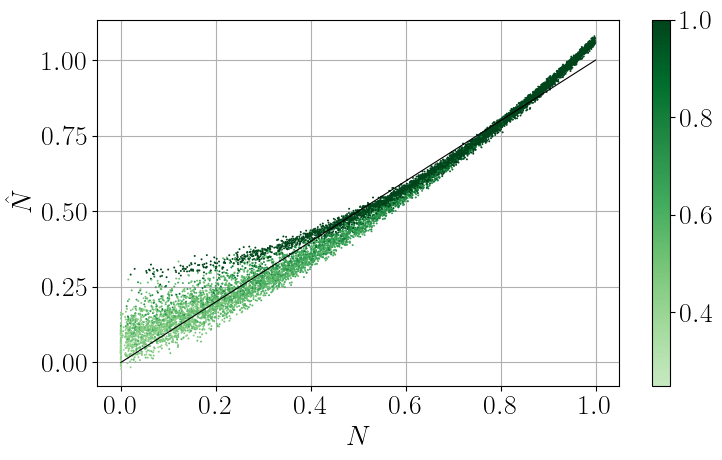

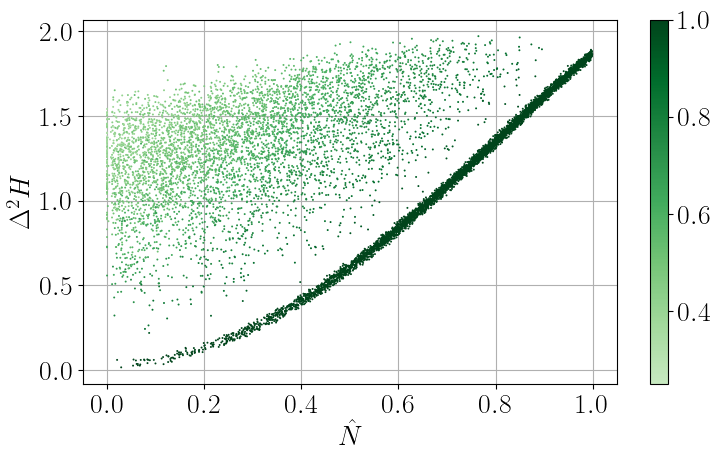

In [17]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_2, n_meas_2, n_layers_2))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Greens"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_2 = sum(np.abs(labels_test - expecs_test_2)**2)/n_test
print("\nError:", sum_err_test_2)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_2, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_2, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

#### 3 copies

In [39]:
n_copies_3 = 3
n_layers_3 = 2
n_tot_3 = n_inp*n_copies_3
n_meas_3 = n_inp*n_copies_3

x0_3 = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_3, n_meas_3, n_layers_3, subsval=0)

file_name = path + "c=%d-m=%d-l=%d-" %(n_copies_3, n_meas_3, n_layers_3) + info + "-pars"

In [40]:
time_start_3 = time()
fvals_3, result_3 = train(dms_train, labels_train, n_layers_3, 
                                n_copies=n_copies_3, n_meas=n_meas_3, x0=x0_3,
                                method=method, w_ls=w_ls, w_var=w_var, options=options, save_data=True, file_name=file_name)
time_finish_3 = time() - time_start_3
print("\n\nFinished in", time_finish_3)
print("Cost:", result_3.fun)
print(result_3.message)
pars_3 = result_3.x

Iteration: 333 | Function value: 1.93232762

Finished in 3250.062233686447
Cost: 1.9323276226879165
Optimization terminated successfully.


In [41]:
expecs_train_3, disps_train_3 = aux_info(dms_train, labels_train, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)
expecs_test_3, disps_test_3 = aux_info(dms_test, labels_test, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)

n_inp: 2 | n_copies: 3 | n_meas: 6 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.002610894676182262


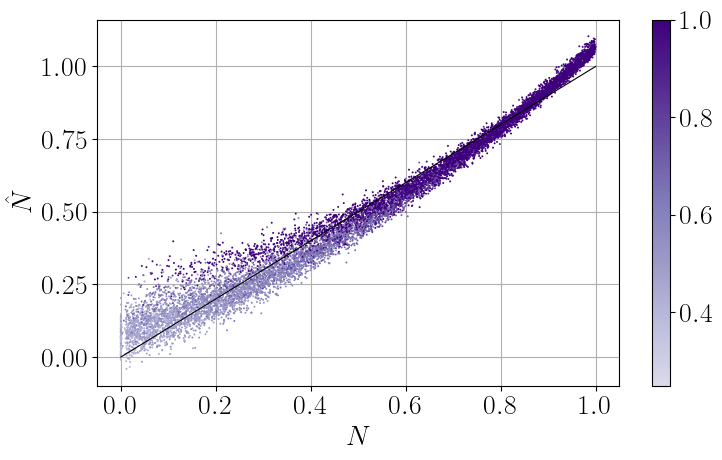

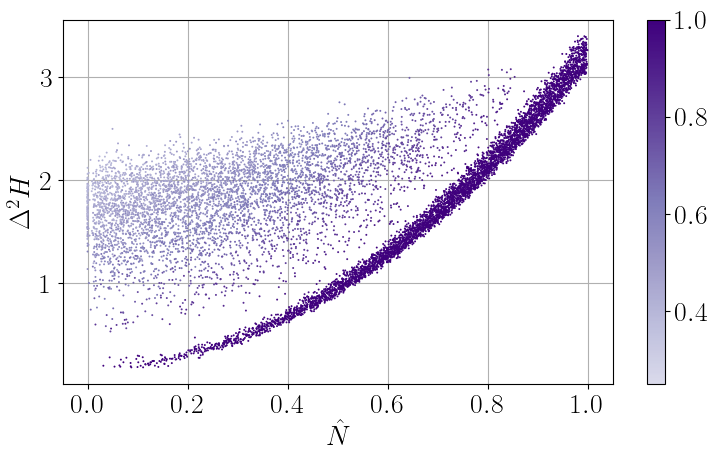

In [42]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_3, n_meas_3, n_layers_3))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Purples"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_3 = sum(np.abs(labels_test - expecs_test_3)**2)/n_test
print("\nError:", sum_err_test_3)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_3, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_3, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

#### 4 copies

In [39]:
n_copies_4 = 3
n_layers_4 = 2
n_tot_4 = n_inp*n_copies_4
n_meas_4 = n_inp*n_copies_4

x0_4 = prev_to_next_ansatz(pars_3, n_tot_3, n_meas_3, n_layers_3, n_tot_4, n_meas_4, n_layers_4, subsval=0)

file_name = path + "c=%d-m=%d-l=%d-" %(n_copies_4, n_meas_4, n_layers_4) + info + "-pars"

In [1]:
time_start_4 = time()
fvals_4, result_4 = train(dms_train, labels_train, n_layers_4, 
                                n_copies=n_copies_4, n_meas=n_meas_4, x0=x0_4,
                                method=method, w_ls=w_ls, w_var=w_var, options=options, save_data=True, file_name=file_name)
time_finish_4 = time() - time_start_4
print("\n\nFinished in", time_finish_4)
print("Cost:", result_4.fun)
print(result_4.message)
pars_4 = result_4.x

In [41]:
expecs_train_4, disps_train_4 = aux_info(dms_train, labels_train, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)
expecs_test_4, disps_test_4 = aux_info(dms_test, labels_test, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)

In [ ]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_4, n_meas_4, n_layers_4))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_4 = sum(np.abs(labels_test - expecs_test_4)**2)/n_test
print("\nError:", sum_err_test_4)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_4, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_4, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

### Training set size

In [6]:
n_inp = 2
n_test = 10000
mixed = True
marks = "neg"

dms_test, labels_test = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)
purities_test = [trace(dm@dm).real for dm in dms_test]

#### 2 copies

In [213]:
w_ls = 1e0
w_var = 1e-4
method = "BFGS"
options = {"maxiter": int(1e4)}#, "maxfun": int(1e10)}#

n_runs = 30


n_copies_2 = 2
n_layers_2 = 2
n_tot_2 = n_inp*n_copies_2
n_meas_2 = n_inp*n_copies_2

# x0_2 = prev_to_next_ansatz(pars_1, n_tot_1, n_meas_1, n_layers_1, n_tot_2, n_meas_2, n_layers_2, subsval=0)
# x0_2_list = [concatenate([normal(pi/2, 0.1, (3*n_tot_2 - 1)*n_layers_2 + 2*n_tot_2), normal(0, 1e-2, 2**n_meas_2)])]
x0_2_list = [concatenate([uniform(0, 2*pi, (3*n_tot_2 - 1)*n_layers_2 + 2*n_tot_2), uniform(-1, 1, 2**n_meas_2)]) for i in range(n_runs)]

n_train_list = [2**i for i in range(2, 11)]
dms_train_list, labels_train_list = [], []
for n_train in n_train_list:
    dms_train, labels_train = gen_even_ent_data(n_train, n_inp=n_inp, mixed=mixed, marks=marks)
    dms_train_list.append(dms_train)
    labels_train_list.append(labels_train)

In [100]:
times_list_2 = []
nfevs_list_2 = []
fvals_list_2 = []
# fopts_list_2 = []
expecs_test_list_2 = []
errors_test_list_2 = []
disps_test_list_2 = []
expecs_train_list_2 = []
errors_train_list_2 = []
disps_train_list_2 = []
pars_list_2 = []
for n_train in n_train_list:
    print("T=", n_train)
    times_r = []
    nfevs_r = []
    fvals_r = []
    # fopts_r = []
    pars_r = []
    expecs_test_r = []
    errors_test_r = []
    disps_test_r = []
    expecs_train_r = []
    errors_train_r = []
    disps_train_r = []
    for r in range(n_runs):
        print("\tr=", r)
        time_start_2 = time()
        fvals_2, result_2 = train(dms_train_list[r], labels_train_list[r], n_layers_2, 
                                  n_copies=n_copies_2, n_meas=n_meas_2, x0=x0_2_list[r],
                                  method=method, w_ls=w_ls, w_var=w_var, options=options, save_data=False, file_name=None)
        time_finish_2 = time() - time_start_2
        print("\n\nFinished in", time_finish_2)
        print("Cost:", result_2.fun)
        print(result_2.message)
        
        expecs_train_2, disps_train_2 = aux_info(dms_train_list[r], labels_train_list[r], n_layers_2, result_2.x, n_copies=n_copies_2, n_meas=n_meas_2)
        expecs_test_2, disps_test_2 = aux_info(dms_test_list[r], labels_test_list[r], n_layers_2, result_2.x, n_copies=n_copies_2, n_meas=n_meas_2)
        errors_train_2 = (expecs_train_2 - labels_train)**2
        errors_test_2 = (expecs_test_2 - labels_test)**2

        print("MSE: %.8f" %np.sum(errors_test_2))
        print("VAR: %.8f" %np.sum(disps_test_2))
        print("_____________________________")
        
        times_r.append(time_finish_2)
        nfevs_r.append(result_2.nfev)
        fvals_r.append(fvals_2)
        # fopts_r.append(result_2.fun)
        pars_r.append(result_2.x)
        expecs_test_r.append(expecs_test_2)
        errors_test_r.append(errors_test_2)
        disps_test_r.append(disps_test_2)
        expecs_train_r.append(expecs_train_2)
        errors_train_r.append(errors_train_2)
        disps_train_r.append(disps_train_2)
    print()
    times_list_2.append(times_r)
    nfevs_list_2.append(nfevs_r)
    fvals_list_2.append(fvals_r)
    # fopts_list_2.append(fopts_r)
    pars_list_2.append(pars_r)
    expecs_test_list_2.append(expecs_test_r)
    errors_test_list_2.append(errors_test_r)
    disps_test_list_2.append(disps_test_r)
    expecs_train_list_2.append(expecs_train_r)
    errors_train_list_2.append(errors_train_r)
    disps_train_list_2.append(disps_train_r)

T= 4
	r= 0
Iteration: 277 | Function value: 0.00001616

Finished in 16.21352529525757
Cost: 1.6162715435587453e-05
Optimization terminated successfully.
MSE: 3134.80408101
VAR: 461.04801493
_____________________________
	r= 1
Iteration: 312 | Function value: 0.00001669

Finished in 16.770163536071777
Cost: 1.6686150789449512e-05
Optimization terminated successfully.
MSE: 2868.44561696
VAR: 443.34976471
_____________________________
	r= 2
Iteration: 226 | Function value: 0.00001681

Finished in 14.060960292816162
Cost: 1.6813966484909363e-05
Optimization terminated successfully.
MSE: 3187.26228754
VAR: 489.66959207
_____________________________
	r= 3
Iteration: 305 | Function value: 0.00002258

Finished in 18.153239965438843
Cost: 2.257809129611257e-05
Optimization terminated successfully.
MSE: 3004.04386353
VAR: 574.01062171
_____________________________
	r= 4
Iteration: 238 | Function value: 0.00001572

Finished in 13.708704471588135
Cost: 1.572091546334384e-05
Optimization terminated

In [155]:
# errors_train_means_2 = np.mean([np.mean(line, axis=1) for line in errors_train_list_2], axis=1)
# disps_train_means_2 = np.mean([np.mean(line, axis=1) for line in disps_train_list_2], axis=1)

w_ls*array([np.sum(line, axis=1) for line in errors_train_list_2]) + w_var*array([np.sum(line, axis=1) for line in disps_train_list_2])

array([[1.61627154e-05, 1.66861508e-05, 1.68139665e-05, 2.25780913e-05,
        1.57209155e-05, 1.56906232e-05, 1.56842660e-05, 2.19915864e-05,
        1.65944610e-05, 1.50845274e-05, 2.09605669e-05, 1.64065763e-05,
        1.33491413e-05, 1.57957074e-05, 1.91548705e-05, 1.75208080e-05,
        1.67206864e-05, 2.30845435e-05, 1.60716404e-05, 2.00559151e-05,
        1.67755687e-05, 1.89372166e-05, 1.47811910e-05, 1.91383943e-05,
        1.99143800e-05, 1.52051078e-05, 2.05136360e-05, 2.15981023e-05,
        1.69154768e-05, 1.77295115e-05],
       [1.10154749e-04, 1.10551118e-04, 9.89628358e-05, 1.00391829e-04,
        1.05331487e-04, 1.10843258e-04, 9.34603982e-05, 1.05326792e-04,
        8.50710791e-05, 9.53870421e-05, 1.11428494e-04, 1.02166644e-04,
        9.96032048e-05, 9.62512931e-05, 9.99678962e-05, 9.43565642e-05,
        9.53848646e-05, 1.08146925e-04, 1.16488849e-04, 9.38560991e-05,
        9.28659667e-05, 8.86300946e-05, 9.09244312e-05, 9.66512777e-05,
        9.58573342e-05,

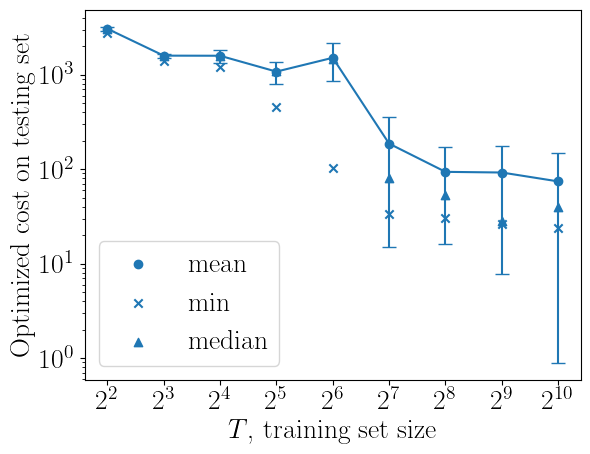

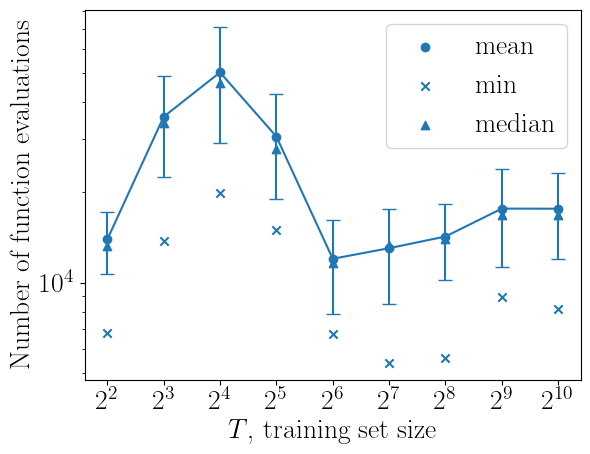

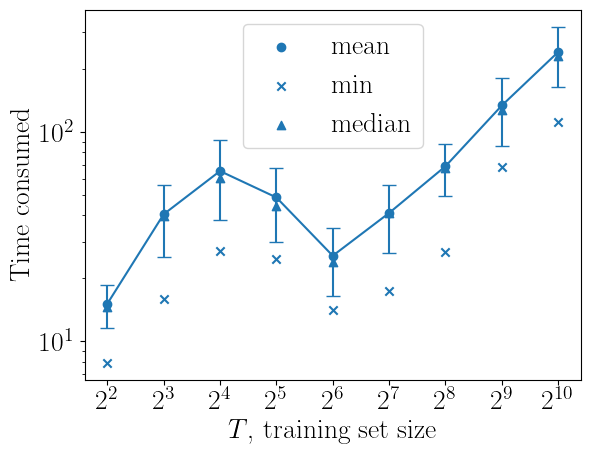

In [211]:
errors_test_means_2 = np.mean([np.sum(line, axis=1) for line in errors_test_list_2], axis=1)
errors_test_stds_2 = np.std([np.sum(line, axis=1) for line in errors_test_list_2], axis=1)
disps_test_means_2 = np.mean([np.sum(line, axis=1) for line in disps_test_list_2], axis=1)
disps_test_stds_2 = np.std([np.sum(line, axis=1) for line in disps_test_list_2], axis=1)

fvals_list_2 = w_ls*array(errors_test_list_2) + w_var*array(disps_test_list_2)
fvals_test_means_2 = np.mean([np.sum(line, axis=1) for line in fvals_list_2], axis=1)
fvals_test_mins_2 = np.min([np.sum(line, axis=1) for line in fvals_list_2], axis=1)
fvals_test_meds_2 = np.median([np.sum(line, axis=1) for line in fvals_list_2], axis=1)
fvals_test_stds_2 = np.std([np.sum(line, axis=1) for line in fvals_list_2], axis=1)

nfevs_test_means_2 = np.mean(nfevs_list_2, axis=1)
nfevs_test_mins_2 = np.min(nfevs_list_2, axis=1)
nfevs_test_meds_2 = np.median(nfevs_list_2, axis=1)
nfevs_test_stds_2 = np.std(nfevs_list_2, axis=1)

times_test_means_2 = np.mean(times_list_2, axis=1)
times_test_mins_2 = np.min(times_list_2, axis=1)
times_test_meds_2 = np.median(times_list_2, axis=1)
times_test_stds_2 = np.std(times_list_2, axis=1)

# arr = w_ls*array([np.sum(line, axis=1) for line in errors_test_list_2]) + w_var*array([np.sum(line, axis=1) for line in disps_test_list_2])
# fvals_test_means_2 = np.mean(arr, axis=1)
# fvals_test_mins_2 = np.min(arr, axis=1)
# fvals_test_stds_2 = np.std(arr, axis=1)

s = 0

plt.errorbar(arange(len(n_train_list))[s:], fvals_test_means_2[s:], yerr=fvals_test_stds_2[s:], capsize=5)
plt.scatter(arange(len(n_train_list))[s:], fvals_test_means_2[s:], marker="o", color="C0", label="mean")
plt.scatter(arange(len(n_train_list))[s:], fvals_test_mins_2[s:], marker="x", color="C0", label="min")
plt.scatter(arange(len(n_train_list))[s:], fvals_test_meds_2[s:], marker="^", color="C0", label="median")
# plt.scatter(arange(len(n_train_list))[s:], array(arr)[arange(len(n_train_list)), inds][s:], marker="p", color="C1", label="min") # for checks
# plt.axhline(0, color="black", linewidth=0.5)
plt.xlabel(r"$T$, training set size")
plt.ylabel(r"Optimized cost on testing set")
plt.xticks(arange(len(n_train_list))[s:], [r"$2^{%d}$"%i for i in range(2+s, 11)])
plt.yscale("log")
plt.legend()
plt.show()

inds = np.argmin([np.sum(line, axis=1) for line in fvals_list_2], axis=1)

plt.errorbar(arange(len(n_train_list))[s:], nfevs_test_means_2[s:], yerr=nfevs_test_stds_2[s:], capsize=5)
plt.scatter(arange(len(n_train_list))[s:], nfevs_test_means_2[s:], marker="o", color="C0", label="mean")
plt.scatter(arange(len(n_train_list))[s:], nfevs_test_mins_2[s:], marker="x", color="C0", label="min")
plt.scatter(arange(len(n_train_list))[s:], nfevs_test_meds_2[s:], marker="^", color="C0", label="median")
# plt.scatter(arange(len(n_train_list))[s:], array(nfevs_list_2)[arange(len(n_train_list)), inds][s:][s:], marker="x", color="C0", label="min")
# plt.scatter(arange(len(n_train_list))[s:], array(arr)[arange(len(n_train_list)), inds][s:], marker="p", color="C1", label="min") # for checks
# plt.axhline(0, color="black", linewidth=0.5)
plt.xlabel(r"$T$, training set size")
plt.ylabel(r"Number of function evaluations")
plt.xticks(arange(len(n_train_list))[s:], [r"$2^{%d}$"%i for i in range(2+s, 11)])
plt.yscale("log")
plt.legend()
plt.show()

plt.errorbar(arange(len(n_train_list))[s:], times_test_means_2[s:], yerr=times_test_stds_2[s:], capsize=5)
plt.scatter(arange(len(n_train_list))[s:], times_test_means_2[s:], marker="o", color="C0", label="mean")
plt.scatter(arange(len(n_train_list))[s:], times_test_mins_2[s:], marker="x", color="C0", label="min")
plt.scatter(arange(len(n_train_list))[s:], times_test_meds_2[s:], marker="^", color="C0", label="median")
# plt.scatter(arange(len(n_train_list))[s:], array(nfevs_list_2)[arange(len(n_train_list)), inds][s:][s:], marker="x", color="C0", label="min")
# plt.scatter(arange(len(n_train_list))[s:], array(arr)[arange(len(n_train_list)), inds][s:], marker="p", color="C1", label="min") # for checks
# plt.axhline(0, color="black", linewidth=0.5)
plt.xlabel(r"$T$, training set size")
plt.ylabel(r"Time consumed")
plt.xticks(arange(len(n_train_list))[s:], [r"$2^{%d}$"%i for i in range(2+s, 11)])
plt.yscale("log")
plt.legend()
plt.show()